# Timeseries Anomaly Detection using Keras
***

Project is based on Keras Timeseries anomaly detection using Autoenoder
https://keras.io/examples/timeseries/timeseries_anomaly_detection/
___

## Evaluation

In [1]:
# Importing required packages Numpy for numerical multi-dimensional arrays
import numpy as np
# Dataframe operations
import pandas as pd
# Neural networks
import tensorflow.keras as keras
# Pyplot for plotting
import matplotlib.pyplot as plt

#### Note:
Current computer configuration does not alow Keras model to be fitted and trained. Posibly due to resource allocation restrictions that is causing bottlenecking and crash of kernel.
After numerous trials GPU processing did not get enabled to perform this tasks an the only viable solution was to set environment variable KMP_DUPLICATE_LIB_OK=TRUE to allow the program to continue to execute. No issues encounterd when running the code on Google colab. Solution addapted from https://stackoverflow.com/a/64816968 with a posibility of silently produced incorrect results.

#### Console error message:
/* 2023-01-05 18:40:33.939491: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
OMP: Error #15: Initializing libiomp5, but found libiomp5md.dll already initialized.
OMP: Hint This means that multiple copies of the OpenMP runtime have been linked into the program. That is dangerous, since it can degrade performance or cause incorrect results. The best thing to do is to ensure that only a single OpenMP runtime is linked into the process, e.g. by avoiding static linking of the OpenMP runtime in any library. As an unsafe, unsupported, undocumented workaround you can set the environment variable KMP_DUPLICATE_LIB_OK=TRUE to allow the program to continue to execute, but that may cause crashes or silently produce incorrect results. For more information, please see http://openmp.llvm.org/ */

In [2]:
# Enabling enironment variable as a workaround for kernel crash issue
import os 
os.environ['KMP_DUPLICATE_LIB_OK']='True'

## Data
___

Timeseries data used for Keras autoencoder anomaly detection is available on [Kaggle](https://www.kaggle.com/datasets/boltzmannbrain/nab). It is known as Numenta Anomaly Benchmark (NAB) and is commonly used for benchmarking and scoring algorithms for detecting anomalies in streaming data. Full information about the dataset is available on [Numenta GitHub](https://github.com/numenta/NAB) page. In this section data will be retrieved and reviewed in its original state.

In [3]:
# Root of URLs
root_url = 'https://raw.githubusercontent.com/numenta/NAB/master/data/'

# Data file without anomaly
no_anomaly_url = root_url + 'artificialNoAnomaly/art_daily_small_noise.csv'

# Data file with anomaly
with_anomaly_url = root_url + 'artificialWithAnomaly/art_daily_jumpsup.csv'

In [4]:
# Panda CSV read is used to retrieve no-anomaly data as df_small_noise
df_small_noise = pd.read_csv(no_anomaly_url, parse_dates=True, index_col="timestamp")

In [5]:
# Looking at top 5 entires to see data format
df_small_noise.head()

,value
timestamp,
2014-04-01 00:00:00,18.324919
2014-04-01 00:05:00,21.970327
2014-04-01 00:10:00,18.624806
2014-04-01 00:15:00,21.953684
2014-04-01 00:20:00,21.909120


In [6]:
# Reviewing descriptive statistics of no-anomaly df
df_small_noise.describe()

,value
count,4032.000000
mean,42.438353
std,28.077122
min,18.000964
25%,19.841390
50%,21.608487
75%,75.450282
max,87.976128


In [7]:
# Looking at zero index row
df_small_noise.iloc[0]

value    18.324919
Name: 2014-04-01 00:00:00, dtype: float64

In [8]:
# Extracting zero index row value under 'value' field
df_small_noise.iloc[0]['value']

18.3249185392

In [9]:
# Same as above only specifying exact value to be returned
df_small_noise.iloc[0].values[0]

18.3249185392

In [10]:
# Checking dataset shape
df_small_noise.shape

(4032, 1)

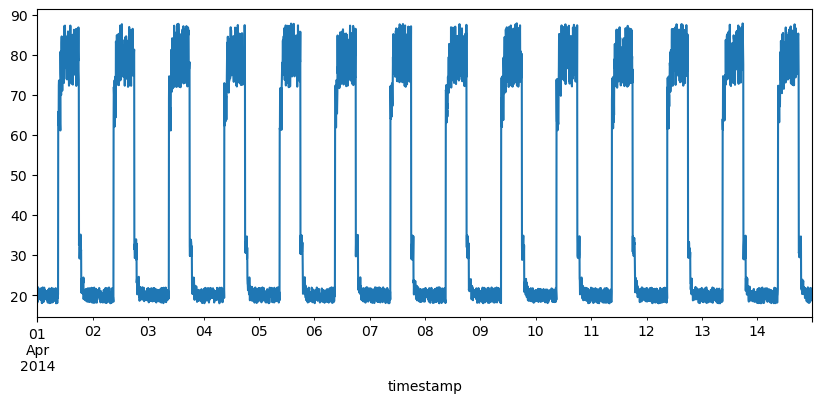

In [11]:
# Setting plot figure axes size
fig, ax = plt.subplots(figsize=(10,4))

# Using pandas to plot data frame.
df_small_noise.plot(legend=False, ax=ax);

In [12]:
# Panda CSV read is used to retrieve anomaly data as df_daily_jumpsup
df_daily_jumpsup = pd.read_csv(with_anomaly_url, parse_dates=True, index_col="timestamp")

In [13]:
# Looking at top 5 entires to see data format
df_daily_jumpsup.head()

,value
timestamp,
2014-04-01 00:00:00,19.761252
2014-04-01 00:05:00,20.500833
2014-04-01 00:10:00,19.961641
2014-04-01 00:15:00,21.490266
2014-04-01 00:20:00,20.187739


In [14]:
# Reviewing descriptive statistics for anomaly df
df_daily_jumpsup.describe()

,value
count,4032.000000
mean,44.494254
std,32.432473
min,18.001010
25%,19.991382
50%,21.648503
75%,76.435943
max,164.947481


In [15]:
# Extracting zero index row value under 'value' field
df_daily_jumpsup.iloc[0]['value']

19.761251903

In [16]:
# Checking dataset shape
df_daily_jumpsup.shape

(4032, 1)

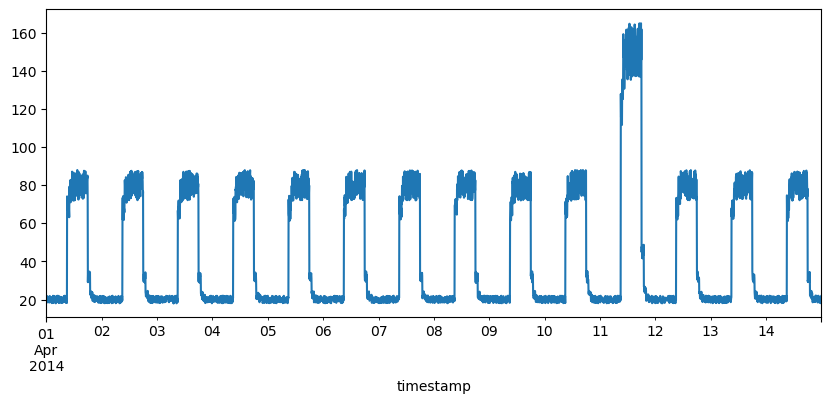

In [17]:
# Setting plot figure axes size
fig, ax = plt.subplots(figsize=(10,4))

# Using pandas to plot data frame.
df_daily_jumpsup.plot(legend=False, ax=ax);

## Prepocessing
___

Once dataset is retrieved and loaded for manipulation the next step is to prepare data for processing. It involves:
- Data Profiling- reviewing data and its statistics to determine if it matches sutablity requirements like observation count and  missing data;
- Data Cleaning- removing missing data fields and NAN values;
- Data Reduction- removing non relevant data to enhance processing speed and reduce errors;
- Data Transformation- arranging data in specific format depending on processing language requirements;
- Data Enrichment- combiling primary data with that retrieved from aditional sources;
- Data Validation- dataset splitting into training and test subsets for verification of model efficiency and accuracy. 





In [18]:
# Recording and returning no-anomaly df mean value
train_mean = df_small_noise.mean()
train_mean

value    42.438353
dtype: float64

In [19]:
# Recording and returning no-anomaly standard deviation value
train_std = df_small_noise.std()
train_std

value    28.077122
dtype: float64

In [20]:
# Z-Score normalization for train values
# Normalising values so the mean is 0 and std deviation is 1
df_train_vals = (df_small_noise - train_mean) / train_std

In [21]:
# Top 5 train data values
df_train_vals.head()

,value
timestamp,
2014-04-01 00:00:00,-0.858829
2014-04-01 00:05:00,-0.728993
2014-04-01 00:10:00,-0.848148
2014-04-01 00:15:00,-0.729586
2014-04-01 00:20:00,-0.731173


In [22]:
# Calculating and appending df with mean and standard deviation of each value
df_small_noise['less_mean'] = df_small_noise['value'] - df_small_noise['value'].mean()
df_small_noise['div_std'] = df_small_noise['less_mean'] / df_small_noise['value'].std()

In [23]:
# Top 5 data values
df_small_noise.head()

,value,less_mean,div_std
timestamp,,,
2014-04-01 00:00:00,18.324919,-24.113435,-0.858829
2014-04-01 00:05:00,21.970327,-20.468026,-0.728993
2014-04-01 00:10:00,18.624806,-23.813547,-0.848148
2014-04-01 00:15:00,21.953684,-20.484669,-0.729586
2014-04-01 00:20:00,21.909120,-20.529234,-0.731173


In [24]:
# Calculating mean of each column
df_small_noise['value'].mean(), df_small_noise['less_mean'].mean(), df_small_noise['div_std'].mean()

(42.438353335806646, -7.342627387941552e-14, -2.616541242931684e-15)

In [25]:
# Calculating standard deviation of each column
df_small_noise['value'].std(), df_small_noise['less_mean'].std(), df_small_noise['div_std'].std()

(28.077122281262515, 28.077122281262508, 1.0000000000000018)

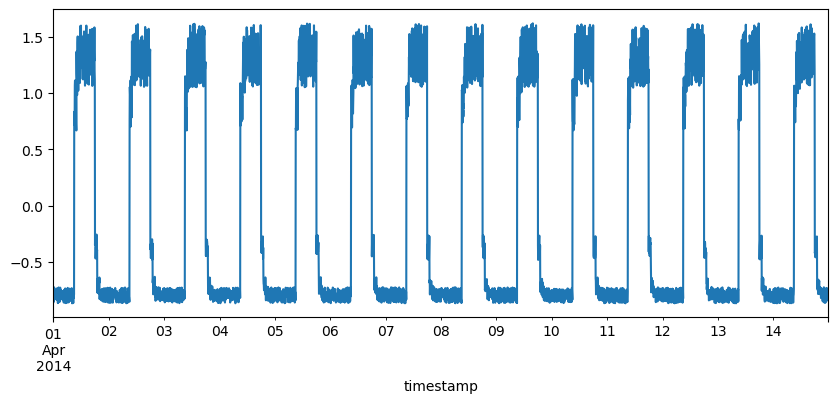

In [26]:
# Setting plot figure axes size
fig, ax = plt.subplots(figsize=(10,4))

# Use pandas to plot normalized data
df_train_vals.plot(legend=False, ax=ax);

In [27]:
# Checking dataset shape
df_train_vals.shape

(4032, 1)

To normalize training data window values are calculated. Dataset has observation every 5 minutes for 14 days hence daily sample is: **24 * 60 / 5 = 288**<br>
Total observations recorded are: **288 * 14 = 288**

In [28]:
# Daily observations
window_size = 288

In [29]:
# Window list example
L = [1, 1, 2, 4, 5, 6, 7, 1, 2, 3, 4, 5]
# Example window size
win_size = 3
# Length of L
len(L)

12

In [30]:
# Number of windows from L
len(L) - (win_size - 1)

10

In [31]:
# Remove brackets
len(L) - win_size + 1

10

In [32]:
# Print the windows
for i in range(len(L) - win_size + 1):
    print(L[i:i + win_size])

[1, 1, 2]
[1, 2, 4]
[2, 4, 5]
[4, 5, 6]
[5, 6, 7]
[6, 7, 1]
[7, 1, 2]
[1, 2, 3]
[2, 3, 4]
[3, 4, 5]


In [33]:
# Array for accumulation of windows
wins = []

# Generating windows
for i in range(len(L) - win_size + 1):
    wins.append(L[i:i + win_size])

wins

[[1, 1, 2],
 [1, 2, 4],
 [2, 4, 5],
 [4, 5, 6],
 [5, 6, 7],
 [6, 7, 1],
 [7, 1, 2],
 [1, 2, 3],
 [2, 3, 4],
 [3, 4, 5]]

In [34]:
# Creating a 2D numpy array from wins
np.stack(wins)

array([[1, 1, 2],
       [1, 2, 4],
       [2, 4, 5],
       [4, 5, 6],
       [5, 6, 7],
       [6, 7, 1],
       [7, 1, 2],
       [1, 2, 3],
       [2, 3, 4],
       [3, 4, 5]])

In [35]:
# Function example to generate training sequences
def windows(vals, N=window_size):
  # Array for accumulation of windows
  L = []
  # For loop for itteration accros each value 
  for i in range(len(vals) - N + 1):
    # Append result to a list 
    L.append(vals[i:i+N])
  # Stack into 2D array
  return np.stack(L)

In [36]:
# Dividing training data into windows
x_train = windows(df_train_vals)

In [37]:
# Checking first an last value
x_train[0][0], x_train[-1][-1]

(array([-0.85882857]), array([-0.8460886]))

In [38]:
# Extracting zero index and last rows
df_train_vals.iloc[0], df_train_vals.iloc[-1]

(value   -0.858829
 Name: 2014-04-01 00:00:00, dtype: float64,
 value   -0.846089
 Name: 2014-04-14 23:55:00, dtype: float64)

In [39]:
# Checking training subset shape
x_train.shape

(3745, 288, 1)

In [40]:
# Checking values of 'value' column
df_train_vals['value'].values

array([-0.85882857, -0.72899302, -0.84814772, ..., -0.83364049,
       -0.73510213, -0.8460886 ])

In [42]:
# Returns one dimensional array
x_train[0].flatten()

array([-0.85882857, -0.72899302, -0.84814772, -0.72958579, -0.731173  ,
       -0.75730984, -0.77645641, -0.7880838 , -0.747012  , -0.829166  ,
       -0.80377285, -0.7821597 , -0.81182078, -0.80949918, -0.82334701,
       -0.79001779, -0.74922405, -0.84169024, -0.73727717, -0.77223023,
       -0.75311352, -0.79116337, -0.75934728, -0.86809294, -0.75381057,
       -0.86468256, -0.74361965, -0.72908121, -0.82850668, -0.84043795,
       -0.76136364, -0.8343536 , -0.74708881, -0.85574949, -0.85245676,
       -0.73090636, -0.77440264, -0.74974936, -0.82419543, -0.77402585,
       -0.78574242, -0.7844733 , -0.77316412, -0.78843253, -0.80927467,
       -0.83109167, -0.76090519, -0.83816509, -0.77176485, -0.83715923,
       -0.78131343, -0.76396862, -0.83924191, -0.86186112, -0.85174179,
       -0.78406773, -0.74938477, -0.86399047, -0.76581026, -0.82177506,
       -0.80222751, -0.73807119, -0.82310669, -0.80410682, -0.86845167,
       -0.85877599, -0.83356075, -0.86643297, -0.78045221, -0.80

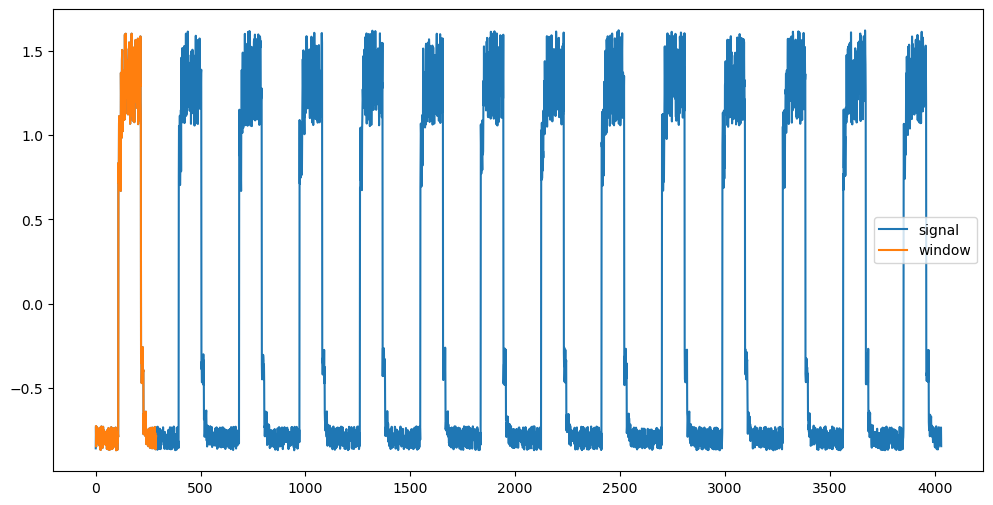

In [43]:
# Selecting window by number
window_no = 1

# Setting plot figure axes size
fig, ax = plt.subplots(figsize=(12, 6))

# Setting trianing set valus as Y
y = df_train_vals['value'].values

# Plotting Y values
ax.plot(np.arange(y.shape[0]), y, label='signal')

# The first window
w = x_train[window_no].flatten()

# Plotting window 1 values only
ax.plot(np.arange(w.shape[0]) + window_no, w, label='window')

ax.legend();

### Neural Network
___

# Description text and pictures

In [45]:
#
layers = [
  #
  keras.layers.Input(shape=(x_train.shape[1], x_train.shape[2])),
  #
  keras.layers.Conv1D(
    filters=32, kernel_size=7, padding="same", strides=2, activation="relu"),
  #
  keras.layers.Dropout(rate=0.2),
  #
  keras.layers.Conv1D(
    filters=16, kernel_size=7, padding="same", strides=2, activation="relu"),
  #
  keras.layers.Conv1DTranspose(
    filters=16, kernel_size=7, padding="same", strides=2, activation="relu"),
  #
  keras.layers.Dropout(rate=0.2),
  #
  keras.layers.Conv1DTranspose(
    filters=32, kernel_size=7, padding="same", strides=2, activation="relu"),
  #
  keras.layers.Conv1DTranspose(filters=1, kernel_size=7, padding="same"),
]

In [46]:
#
model = keras.Sequential(layers)

In [47]:
# 
optimizer = keras.optimizers.Adam(learning_rate=0.001)

In [48]:
# 
model.compile(optimizer=optimizer, loss="mse")

In [49]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_2 (Conv1D)           (None, 144, 32)           256       
                                                                 
 dropout_2 (Dropout)         (None, 144, 32)           0         
                                                                 
 conv1d_3 (Conv1D)           (None, 72, 16)            3600      
                                                                 
 conv1d_transpose_3 (Conv1DT  (None, 144, 16)          1808      
 ranspose)                                                       
                                                                 
 dropout_3 (Dropout)         (None, 144, 16)           0         
                                                                 
 conv1d_transpose_4 (Conv1DT  (None, 288, 32)          3616      
 ranspose)                                              

In [50]:
# 
history = model.fit(
    x_train,
    x_train,
    epochs=50,
    batch_size=128,
    validation_split=0.1,
    callbacks=[
        keras.callbacks.EarlyStopping(monitor="val_loss", patience=5, mode="min")
    ],
)

Epoch 1/50
27/27 [==============================] - 3s 58ms/step - loss: 0.5504 - val_loss: 0.3074
Epoch 2/50
27/27 [==============================] - 1s 41ms/step - loss: 0.1504 - val_loss: 0.0474
Epoch 3/50
27/27 [==============================] - 1s 38ms/step - loss: 0.0613 - val_loss: 0.0356
Epoch 4/50
27/27 [==============================] - 1s 36ms/step - loss: 0.0475 - val_loss: 0.0289
Epoch 5/50
27/27 [==============================] - 1s 36ms/step - loss: 0.0402 - val_loss: 0.0264
Epoch 6/50
27/27 [==============================] - 1s 36ms/step - loss: 0.0358 - val_loss: 0.0253
Epoch 7/50
27/27 [==============================] - 1s 38ms/step - loss: 0.0328 - val_loss: 0.0222
Epoch 8/50
27/27 [==============================] - 1s 41ms/step - loss: 0.0304 - val_loss: 0.0243
Epoch 9/50
27/27 [==============================] - 1s 37ms/step - loss: 0.0281 - val_loss: 0.0239
Epoch 10/50
27/27 [==============================] - 1s 35ms/step - loss: 0.0265 - val_loss: 0.0242
Epoch 11/

### Evaluation
___

In [ ]:
history.history["loss"];

In [ ]:
history.history["val_loss"];

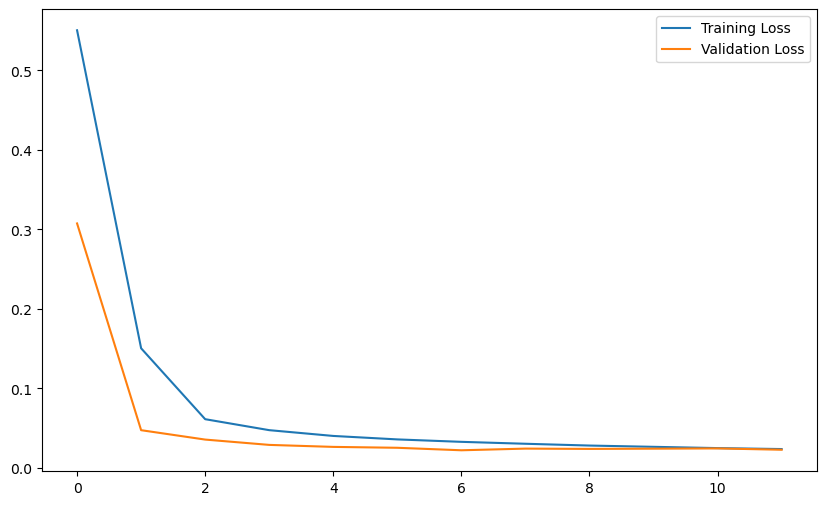

In [51]:
# Setting plot figure axes size
fig, ax = plt.subplots(figsize=(10, 6))
# Plotting data line for training loss
ax.plot(history.history["loss"], label="Training Loss")
# Plotting data line for validation Loss
ax.plot(history.history["val_loss"], label="Validation Loss")
# Including plot legend
ax.legend();

In [73]:
# Getting train MAE loss
x_train_pred = model.predict(x_train)

118/118 [==============================] - 1s 5ms/step


In [72]:
# Calculating loss
train_mae_loss = np.mean(np.abs(x_train_pred - x_train), axis=1)

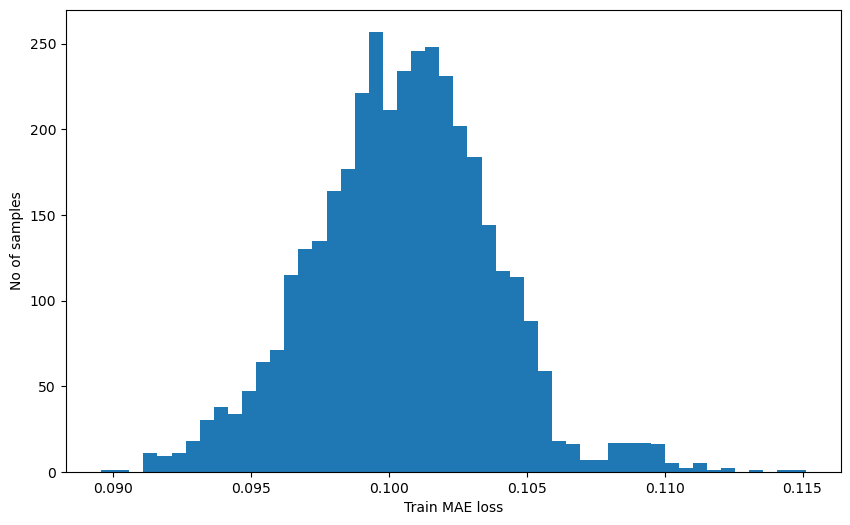

In [59]:
# Setting plot figure axes size
fig, ax = plt.subplots(figsize=(10, 6))
# Histogram of MAE loss
ax.hist(train_mae_loss, bins=50)
# x axis label
ax.set_xlabel("Train MAE loss")
# y axis label
ax.set_ylabel("No of samples");

In [61]:
# Get reconstruction loss threshold.
threshold = np.max(train_mae_loss)

# Output threshold value
threshold

0.1151132070367229

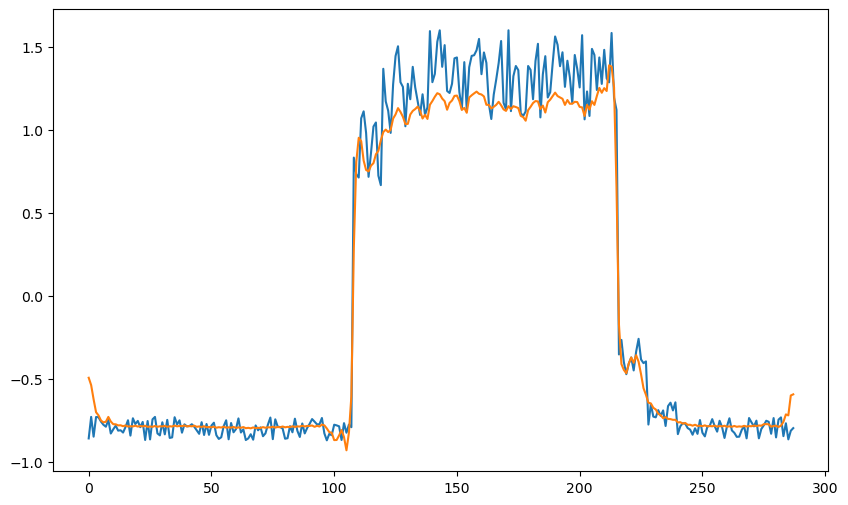

In [63]:
# Setting plot figure axes size
fig, ax = plt.subplots(figsize=(10, 6))

# Ploting actual values
ax.plot(x_train[0])

# Plotting predicted values
ax.plot(x_train_pred[0]);

In [66]:
# Z-Score normalization for test values
df_test_value = (df_daily_jumpsup - train_mean) / train_std

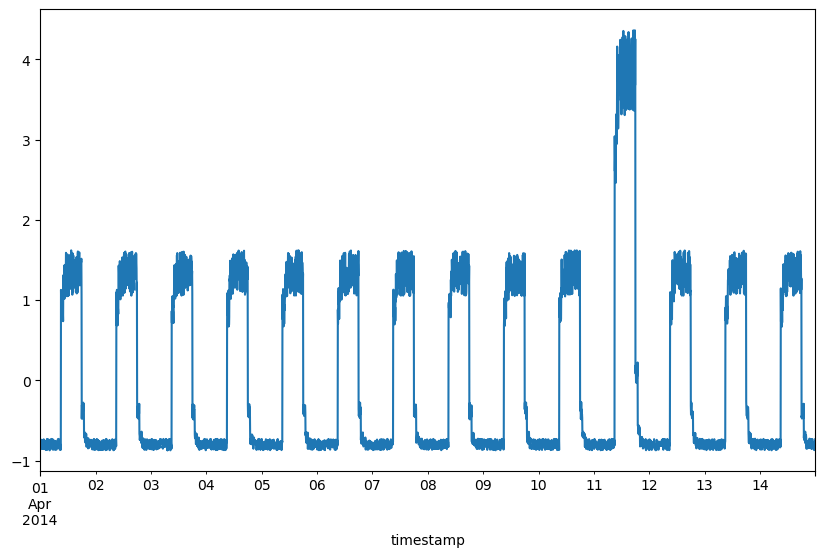

In [68]:
# Setting plot figure axes size
fig, ax = plt.subplots(figsize=(10, 6))

# Plotting dataset with anomaly
df_test_value.plot(legend=False, ax=ax);

In [69]:
# Creating sequences from test values
x_test = windows(df_test_value.values)

# Output data value
x_test.shape

(3745, 288, 1)

In [70]:
# Running prediction model
x_test_pred = model.predict(x_test)

118/118 [==============================] - 1s 5ms/step


In [74]:
# Calculating loss
test_mae_loss = np.mean(np.abs(x_test_pred - x_test), axis=1)

# Show loss values
test_mae_loss

array([[0.09694093],
       [0.10076499],
       [0.09802319],
       ...,
       [0.09986268],
       [0.10032695],
       [0.098351  ]])

In [76]:
# Reshapping results to 1d array
test_mae_loss = test_mae_loss.reshape((-1))

# Show loss values
test_mae_loss

array([0.09694093, 0.10076499, 0.09802319, ..., 0.09986268, 0.10032695,
       0.098351  ])

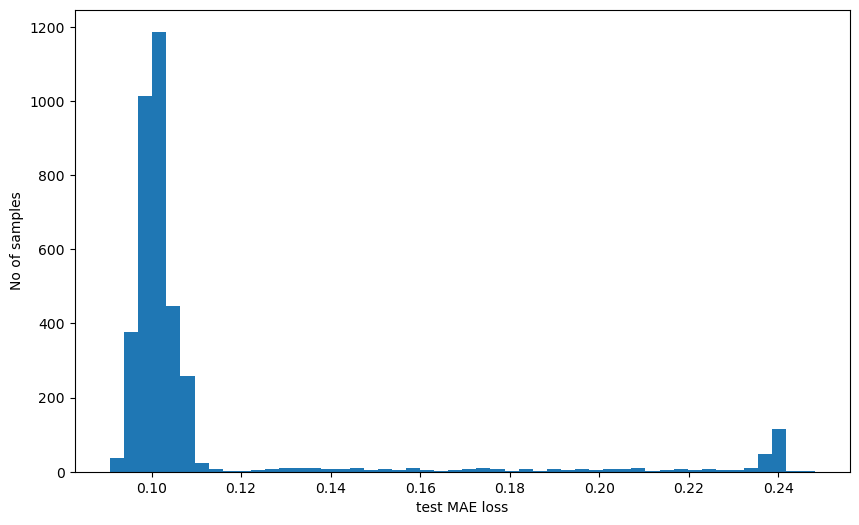

In [77]:
# Setting plot figure axes size
fig, ax = plt.subplots(figsize=(10, 6))

# Ploting loss values
ax.hist(test_mae_loss, bins=50)

# x axis label
ax.set_xlabel("test MAE loss")

# y axis label
ax.set_ylabel("No of samples");

In [78]:
# Detect all the samples which are anomalies
anomalies = test_mae_loss > threshold

# Number of anomalies
np.sum(anomalies)

395

In [79]:
# data i is an anomaly if samples [(i - timesteps + 1) to (i)] are anomalies
inds = []

for i in range(window_size - 1, len(df_test_value) - window_size + 1):
    if np.all(anomalies[i - window_size + 1 : i]):
        inds.append(i)

In [83]:
# Creating data subset to highlight windows that has anomaly
df_subset = df_daily_jumpsup.iloc[inds]

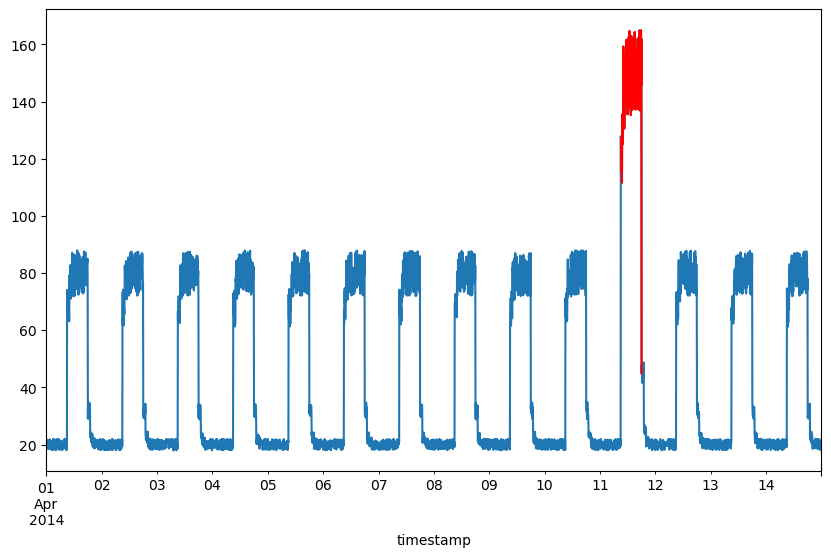

In [85]:
# Setting plot figure axes size
fig, ax = plt.subplots(figsize=(10, 6))

# Plotting anomaly dataset
df_daily_jumpsup.plot(legend=False, ax=ax)

# Plotting anumaly observations to highlight them in red
df_subset.plot(legend=False, ax=ax, color="r");

References:<br>

https://www.techtarget.com/searchdatamanagement/definition/data-preprocessing<br>
https://www.geeksforgeeks.org/data-preprocessing-in-data-mining/<br>
https://www.statology.org/z-score-normalization/<br>


___

## The End.